<a href="https://colab.research.google.com/github/eg048/data/blob/master/33_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify images of clothing

*The content of this notebook is mainly based on Laurence Moroney's video tutorial [Basic Computer Vision with ML](https://www.youtube.com/watch?v=bemDFpNooA8) and
the TensorFlow tutorial "Basic classification: Classify images of clothing". Here is the original source code:*

 <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>

In this tutorial we are going to train a sequential neural network model to classify images of clothing, like sneakers and shirts. We will use [keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Setup

In [2]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


## Import data

We use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Data exploration

Let's explore the format of the dataset before training the model.

If you inspect the first image in the training set, you will see that each picture is represented as 28 x 28 pixels and that the pixel values fall in the range of 0 to 255:

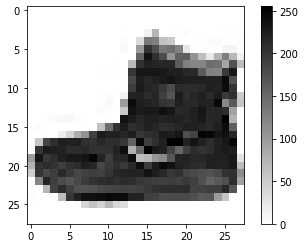

In [8]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels. 

In [9]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [10]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [11]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

And the test set contains 10,000 images labels:

In [12]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. Remember that the pixel values fall in the range of 0 to 255. 

We need to scale these values to a range of 0 to 1 before feeding them to the neural network model. 

To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [15]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

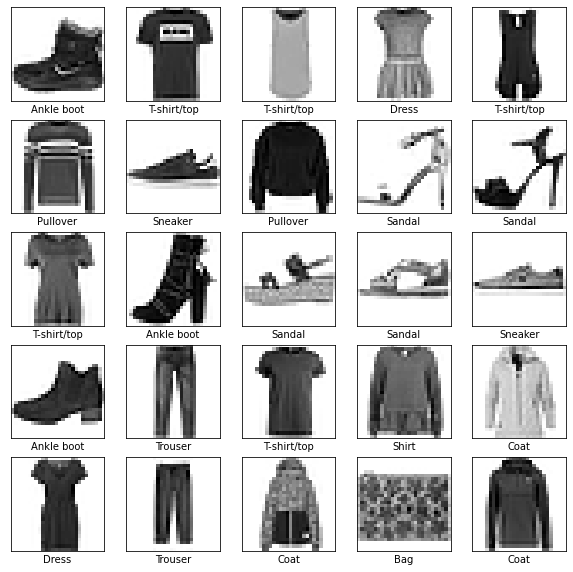

In [16]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). 

Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `layers.Dense`, have parameters that are learned during training.

In [20]:
model = keras.Sequential(
    [
        layers.Flatten(input_shape=(28, 28), name="layer1"),
        layers.Dense(128, activation='relu', name="layer2"),
        layers.Dense(60, activation='relu', name="layer2b"),
        layers.Dropout(0.05, name="layer3"),
        layers.Dense(10, name="layer4")
])

`layer1`:

- The first layer in this network, `layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). 
- Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.



`layer2`:

- The first `Dense` layer has 128 nodes (also called functions or neurons). 
- Each layer of neurons need an **activation function** to tell them what to do. 
- **Relu** effectively means "If X>0 return X, else return 0". So it only passes values 0 or greater to the next layer in the network.

`layer3:` 

 - The ``Dropout`` layer randomly sets input units to 0 with a given frequency rate at each step during training time, which helps prevent overfitting. 



`layer4`:

- This layer returns a [logit](https://en.wikipedia.org/wiki/Logit) array with length of 10. 
- The logit is a type of function that maps probability values from 0 to 1 to real numbers in the range of  $-\infty$ to $+\infty$.
- This simply means that each node contains a score (also called "log-odd") that indicates how likely it is that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [21]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

To train the neural network model, we feed the training data to the model. 

- The training data is in the `train_images` and `train_labels` arrays.
- We also need to choose the number of epochs to train the model. 


To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 2s 798us/step - loss: 0.5094 - accuracy: 0.8222
Epoch 2/10
1875/1875 [==============================] - 1s 757us/step - loss: 0.3856 - accuracy: 0.8615
Epoch 3/10
1875/1875 [==============================] - 1s 729us/step - loss: 0.3480 - accuracy: 0.8726
Epoch 4/10
1875/1875 [==============================] - 1s 755us/step - loss: 0.3237 - accuracy: 0.8815
Epoch 5/10
1875/1875 [==============================] - 1s 785us/step - loss: 0.3076 - accuracy: 0.8860
Epoch 6/10
1875/1875 [==============================] - 1s 734us/step - loss: 0.2933 - accuracy: 0.8918
Epoch 7/10
1875/1875 [==============================] - 1s 746us/step - loss: 0.2816 - accuracy: 0.8951
Epoch 8/10
1875/1875 [==============================] - 1s 792us/step - loss: 0.2726 - accuracy: 0.8990
Epoch 9/10
1875/1875 [==============================] - 2s 820us/step - loss: 0.2615 - accuracy: 0.9011
Epoch 10/10
1875/1875 [==============================] - 1s 776u

As the model trains, the loss and accuracy metrics are displayed.

### Evaluate accuracy

Next, compare how the model performs on the test dataset. This means you ask the model to make predictions about a test set. In this example, the `test_images` array.


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f' Test accuracy: {test_acc:.3f} \n Test loss {test_loss:.3f}')

313/313 - 0s - loss: 0.3213 - accuracy: 0.8853 - 232ms/epoch - 741us/step
 Test accuracy: 0.885 
 Test loss 0.321


If the accuracy on the test dataset is less than the accuracy on the training dataset, this gap represents *overfitting*. 

Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data.

### Make predictions

With the model trained, you can use it to make predictions about some images. We attach a `softmax` layer to convert the model's linear outputs (logits) to probabilities (percentages), which are be easier to interpret:

In [ ]:
probability_model = keras.Sequential([
                        model, layers.Softmax()
                        ])

In [ ]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([2.7214844e-08, 3.5939223e-08, 1.3246297e-07, 1.9636468e-08,
       1.3148453e-07, 6.5520611e-03, 5.3073709e-08, 1.8532565e-02,
       1.5230922e-08, 9.7491497e-01], dtype=float32)

- A prediction is an array of 10 numbers. 
- They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing.

You can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
test_labels[0]

9

### Verify predictions

Let's write functions to graph the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

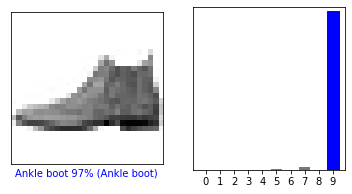

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)

plot_value_array(i, predictions[i],  test_labels)
plt.show()

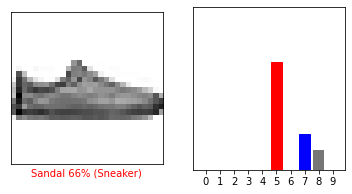

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

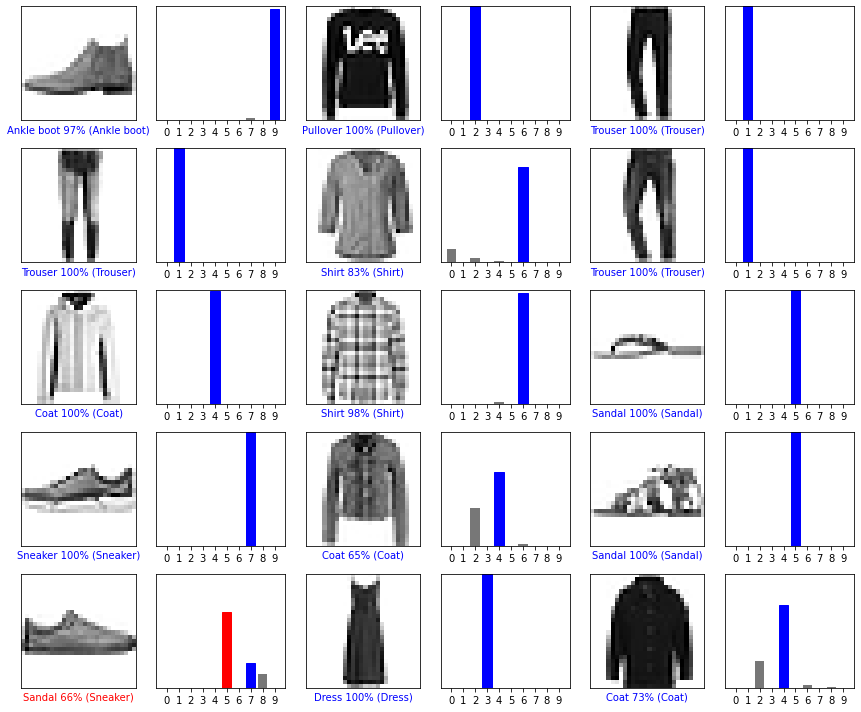

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[1.1900232e-05 1.4200392e-13 9.9936157e-01 2.2404726e-11 4.0746501e-04
  8.0609104e-12 2.1913306e-04 4.2981963e-18 3.5087393e-08 8.4743935e-15]]


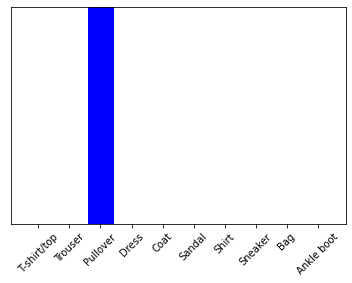

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.